In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, Subset
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import os
import cv2
from sklearn.model_selection import train_test_split
import helper
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2
from collections import defaultdict
import random
from PIL import Image
import torchvision.transforms as F
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Augmentation



In [ ]:
train_set_d = "drive/MyDrive/Deep Learning - Group Project/data/train_images/train_images"
masks_d = "drive/MyDrive/Deep Learning - Group Project/data/train_masks/train_masks"

train_images = glob.glob(train_set_d + "/*.jpg")
masks = glob.glob(masks_d + "/*.png")

print("Number of Train Images:",len(train_images))
print("Number of Train Masks:",len(masks))

Number of Train Images: 261
Number of Train Masks: 261


In [ ]:
def largest_rotated_rect(w, h, angle):

    quadrant = int(math.floor(angle / (math.pi / 2))) & 3
    sign_alpha = angle if ((quadrant & 1) == 0) else math.pi - angle
    alpha = (sign_alpha % math.pi + math.pi) % math.pi

    bb_w = w * math.cos(alpha) + h * math.sin(alpha)
    bb_h = w * math.sin(alpha) + h * math.cos(alpha)

    gamma = math.atan2(bb_w, bb_w) if (w < h) else math.atan2(bb_w, bb_w)

    delta = math.pi - alpha - gamma

    length = h if (w < h) else w

    d = length * math.cos(alpha)
    a = d * math.sin(alpha) / math.sin(delta)

    y = a * math.cos(gamma)
    x = y * math.tan(gamma)

    return (
        bb_w - 2 * x,
        bb_h - 2 * y
    )

def data_augmentation(images,masks,img_out,mask_out,n_min=5000):
  #Counting Number of labeled pixels for each category
  labels = defaultdict(lambda:0)
  containing_imgs = defaultdict(lambda : defaultdict(lambda:0))
  aug = 0
  print("Counting")
  for k , im_p in enumerate(masks):
    if k % 50 == 0:
      print(k+1,"/",len(masks))
    im = cv2.imread(im_p,0)
    im = cv2.resize(im,(1024,1024)).flatten()
    for i in im :
      labels[i] = labels[i]+1
      containing_imgs[i][k] += 1
  print(containing_imgs)
  print("End counting")
  print(max(labels.values()))

  objective = int(n_min)
  print("Trying to augment each label till having min = ", objective)
  labels = {k: v for k, v in sorted(labels.items(), key=lambda item: item[1])}

  for key in labels :
      while labels[key] < objective :
        # We randomly select an image containing our label : 
        id = random.randint(0,len(containing_imgs[key].keys())-1)
        tab = [*containing_imgs[key]]
        id = tab[id]
        # We randomly apply one of the transformations to the image
        t = random.uniform(0, 1)
        mask_to_t = cv2.imread(masks[id])
        to_transform = cv2.imread(train_set_d+"/"+masks[id].split("/")[-1].split(".")[0]+".jpg")
        to_transform = torch.from_numpy(to_transform.transpose(2,0,1))
        mask_to_t = torch.from_numpy(mask_to_t.transpose(2,0,1))

        new_image = torch.zeros(to_transform.shape)
        new_mask = torch.zeros(mask_to_t.shape)
        print(masks_d+"/"+images[id].split("/")[-1].split(".")[0]+".png")
       

        if t < 0.5 : # Oversampling  + Random Pixel modification
          new_image = to_transform
          new_mask  = mask_to_t
          b = random.uniform(0, 1)
          if b < 0.3 :
            cjit = F.ColorJitter(random.uniform(0, 1),random.uniform(0, 1),random.uniform(0, 1),random.uniform(0, 0.5))
            new_image = cjit(new_image)
            pass
          elif b < 0.7 :
            cjit = F.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
            new_image = cjit(new_image)
            pass
          else :
            cjit = F.RandomAutocontrast(p=0.5)
            new_image = cjit(new_image)
          

          
        elif t <= 0.8 : # Random Cropping
          r = random.uniform(0.5,1)
          r2 = random.uniform(0.5,1)
         
          x, y, h, w =  F.RandomCrop.get_params(to_transform,(int(to_transform.shape[1]*r),int(to_transform.shape[2]*r2)))
          new_image = F.functional.crop(to_transform,x, y, h, w)
          new_mask  = F.functional.crop(mask_to_t,x, y, h, w)

          pass
        
        else : #Rotating + Center Cropping
          deg = [0,90]
          
          func = F.RandomRotation(deg)
          param = func.get_params(deg)
          new_image = F.functional.rotate(to_transform,param,expand=True)
          new_mask  = F.functional.rotate(mask_to_t,param,expand=True)
          rect_w,rect_h = largest_rotated_rect(to_transform.shape[0], to_transform.shape[1],math.radians(param))
          print(rect_h," " ,rect_w)
          new_image = F.CenterCrop((int(abs(rect_h)), int(abs(rect_w)))).forward(new_image)
          new_mask = F.CenterCrop((int(abs(rect_h)), int(abs(rect_w)))).forward(new_mask)
          pass

        aug += 1
        #Update labels count
        

        im = cv2.resize(cv2.cvtColor(new_mask.numpy().transpose(1, 2, 0),cv2.COLOR_BGR2GRAY),(1024,1024)).flatten()
        plt.imshow(cv2.cvtColor(new_mask.numpy().transpose(1, 2, 0),cv2.COLOR_BGR2GRAY))
        for u in im :
          if u in labels.keys(): 
            labels[u] = labels[u] + 1
        #Save new Image
        cv2.imwrite(img_out+"/"+str(aug)+".jpg",new_image.numpy().transpose(1, 2, 0))
        cv2.imwrite(mask_out+"/"+str(aug)+".png",new_mask.numpy().transpose(1, 2, 0))

  pass

def load_quasi_uniform_dataset(masks,images,n,min_representation=5000):
  labels = defaultdict(lambda:0)
  containing_imgs = defaultdict(lambda : defaultdict(lambda:0))
  aug = 0
  print("Counting")
  for k , im_p in enumerate(masks):
    if k % 50 == 0:
      print(k+1,"/",len(masks))
    im = cv2.imread(im_p,0)
    im = cv2.resize(im,(1024,1024)).flatten()
    for i in im :
      labels[i] = labels[i]+1
      containing_imgs[i][k] += 1
  print(containing_imgs)
  print("End counting")
  print(max(labels.values()))

  objective = int(min_representation)
  print("Trying to load dataset with min representation = ", objective,".\n And randomly (uniform) select missing images.\n Oversampling may happen ")
  labels = {k: v for k, v in sorted(labels.items(), key=lambda item: item[1])}

  dataset = []
  mask_set = []
  o = 0
  for key in labels :
    if labels[key] < objective : 
      print("Label n° ",key, " ,is not enough represented to ensure having ",min_representation)
      return [] , []
    else : 
      p = 0
      for id in containing_imgs[key].keys():
        mask_set.append(masks[id])
        dataset.append(train_set_d+"/"+masks[id].split("/")[-1].split(".")[0]+".jpg")
        p = p + containing_imgs[key][id]
        o += 1
        if p >= min_representation:
          break
  while o < n : 
    l = random.randint(0,len(masks)-1)
    mask_set.append(masks[l])
    dataset.append(train_set_d+"/"+masks[l].split("/")[-1].split(".")[0]+".jpg")  
  return mask_set , dataset
  pass

In [ ]:
train_set_aug = "drive/MyDrive/Deep Learning - Group Project/data/train_images/train_images_aug"
masks_aug = "drive/MyDrive/Deep Learning - Group Project/data/train_masks/train_masks_aug"

Counting
1 / 261
51 / 261
101 / 261
151 / 261
201 / 261
251 / 261
defaultdict(<function data_augmentation.<locals>.<lambda> at 0x7fd534c20560>, {0: defaultdict(<function data_augmentation.<locals>.<lambda>.<locals>.<lambda> at 0x7fd534bf9b90>, {0: 41659, 1: 84232, 2: 115901, 3: 85295, 4: 110914, 5: 302997, 6: 140144, 7: 76553, 8: 161165, 9: 154920, 10: 79844, 11: 203183, 12: 209969, 13: 183651, 14: 407796, 15: 63840, 16: 179145, 17: 102236, 18: 56019, 19: 128414, 20: 257564, 21: 97988, 22: 47563, 23: 165340, 24: 117043, 25: 119857, 26: 177156, 27: 145427, 28: 221151, 29: 192569, 30: 138273, 31: 74307, 32: 17628, 33: 278636, 34: 92779, 35: 241942, 36: 84078, 37: 63717, 38: 215015, 39: 182531, 40: 126381, 41: 59364, 42: 311596, 43: 71759, 44: 153281, 45: 38825, 46: 108279, 47: 68493, 48: 418712, 49: 146389, 50: 144805, 51: 108812, 52: 60165, 53: 345833, 54: 68984, 55: 50443, 56: 113064, 57: 111253, 58: 161227, 59: 261232, 60: 111022, 61: 149981, 62: 164161, 63: 103858, 64: 128742, 65: 21

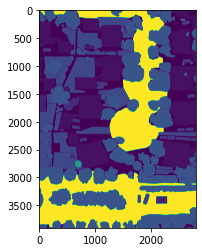

In [ ]:
data_augmentation(train_images,masks,train_set_aug,masks_aug,n_min=70000)

# Preparing Data

In this section, we prepare data for training.

In [ ]:
class SegmentationDataset(Dataset):
    # resize_shape is in the format (height,width) (e.g. (4000,3000) for most of our dataset)
    def __init__(self, imagePaths, maskPaths, image_transform, mask_transform, resize_shape=(512,512)):
        # store the image and mask filepaths, and augmentation
        # transforms
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.resize_shape = resize_shape

    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.imagePaths)

    def __getitem__(self, idx):
        # grab the image path from the current index
        imagePath = self.imagePaths[idx]
        
        # load the image from disk, swap its channels from BGR to RGB,
        # and read the associated mask from disk in grayscale mode
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.maskPaths[idx], 0)
        
        # use INTER_AREA for image resize and INTER_NEAREST for mask resize
        image_res = cv2.resize(image, self.resize_shape, interpolation=cv2.INTER_AREA)
        mask_res = cv2.resize(mask, self.resize_shape, interpolation=cv2.INTER_NEAREST).astype('float32')

        # apply the transformations to both image and its mask
        image = self.image_transform(image_res)
        image = image / 255
        mask = self.mask_transform(mask_res)
        # removing unnecessary dimension and converting to type Long
        mask = mask.squeeze().long()
        
        # return a tuple of the image and its mask
        return (image, mask)

In [ ]:
def train_tune_dataset(dataset, tune_split=0.1):
    train_idx, tune_idx = train_test_split(list(range(len(dataset))), test_size=tune_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['tune'] = Subset(dataset, tune_idx)
    return datasets

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

In [ ]:
imagePath = "drive/MyDrive/Deep Learning - Group Project/data/train_images/train_images/"
imageAugPath = "drive/MyDrive/Deep Learning - Group Project/data/train_images/train_images_aug/"
maskPath = "drive/MyDrive/Deep Learning - Group Project/data/train_masks/train_masks/"
maskAugPath = "drive/MyDrive/Deep Learning - Group Project/data/train_masks/train_masks_aug/"
testPath = "drive/MyDrive/Deep Learning - Group Project/data/test_images/test_images/"

In [ ]:
imagePaths  = sorted([os.path.join(imagePath,path) for path in os.listdir(imagePath)]) + sorted([os.path.join(imageAugPath,path) for path in os.listdir(imageAugPath)])
maskPaths = sorted([os.path.join(maskPath,path) for path in os.listdir(maskPath)]) + sorted([os.path.join(maskAugPath,path) for path in os.listdir(maskAugPath)])
testPaths = [os.path.join(testPath,path) for path in os.listdir(testPath)]

# Building Model

In this section, we build our U-Net model.

In [ ]:
class UNet(nn.Module):
    def __init__(self,input_channels=3,feature_maps=8,output_channels=25):
        super(UNet,self).__init__()
        
        # ENCODER
        self.conv11 = nn.Conv2d(input_channels,feature_maps,3,stride=1,padding='same')
        self.batchnorm11 = nn.BatchNorm2d(feature_maps)
        self.conv12 = nn.Conv2d(feature_maps,feature_maps,3,stride=1,padding='same')
        self.batchnorm12 = nn.BatchNorm2d(feature_maps)
        # Using convolutions for downsampling rather than max-pooling
        self.down1 = nn.Conv2d(feature_maps,feature_maps,2,stride=2)
        self.conv21 = nn.Conv2d(feature_maps,2*feature_maps,3,stride=1,padding='same')
        self.batchnorm21 = nn.BatchNorm2d(2*feature_maps)
        self.conv22 = nn.Conv2d(2*feature_maps,2*feature_maps,3,stride=1,padding='same')
        self.batchnorm22 = nn.BatchNorm2d(2*feature_maps)
        self.down2 = nn.Conv2d(2*feature_maps,2*feature_maps,2,stride=2)
        self.conv31 = nn.Conv2d(2*feature_maps,4*feature_maps,3,stride=1,padding='same')
        self.batchnorm31 = nn.BatchNorm2d(4*feature_maps)
        self.conv32 = nn.Conv2d(4*feature_maps,4*feature_maps,3,stride=1,padding='same')
        self.batchnorm32 = nn.BatchNorm2d(4*feature_maps)
        self.down3 = nn.Conv2d(4*feature_maps,4*feature_maps,2,stride=2)
        self.conv41 = nn.Conv2d(4*feature_maps,8*feature_maps,3,stride=1,padding='same')
        self.batchnorm41 = nn.BatchNorm2d(8*feature_maps)
        self.conv42 = nn.Conv2d(8*feature_maps,8*feature_maps,3,stride=1,padding='same')
        self.batchnorm42 = nn.BatchNorm2d(8*feature_maps)
        self.down4 = nn.Conv2d(8*feature_maps,8*feature_maps,2,stride=2)
        self.conv51 = nn.Conv2d(8*feature_maps,16*feature_maps,3,stride=1,padding='same')
        self.batchnorm51 = nn.BatchNorm2d(16*feature_maps)
        
        # DECODER
        self.conv52 = nn.Conv2d(16*feature_maps,16*feature_maps,3,stride=1,padding='same')
        self.batchnorm52 = nn.BatchNorm2d(16*feature_maps)
        # Using transpose convolutions for up-sampling in response to convolutions for downsampling
        self.up1 = nn.ConvTranspose2d(16*feature_maps,8*feature_maps,2,stride=2)
        self.conv61 = nn.Conv2d(16*feature_maps,8*feature_maps,3,stride=1,padding='same')
        self.batchnorm61 = nn.BatchNorm2d(8*feature_maps)
        self.conv62 = nn.Conv2d(8*feature_maps,8*feature_maps,3,stride=1,padding='same')
        self.batchnorm62 = nn.BatchNorm2d(8*feature_maps)
        self.up2 = nn.ConvTranspose2d(8*feature_maps,4*feature_maps,2,stride=2)
        self.conv71 = nn.Conv2d(8*feature_maps,4*feature_maps,3,stride=1,padding='same')
        self.batchnorm71 = nn.BatchNorm2d(4*feature_maps)
        self.conv72 = nn.Conv2d(4*feature_maps,4*feature_maps,3,stride=1,padding='same')
        self.batchnorm72 = nn.BatchNorm2d(4*feature_maps)
        self.up3 = nn.ConvTranspose2d(4*feature_maps,2*feature_maps,2,stride=2)
        self.conv81 = nn.Conv2d(4*feature_maps,2*feature_maps,3,stride=1,padding='same')
        self.batchnorm81 = nn.BatchNorm2d(2*feature_maps)
        self.conv82 = nn.Conv2d(2*feature_maps,2*feature_maps,3,stride=1,padding='same')
        self.batchnorm82 = nn.BatchNorm2d(2*feature_maps)
        self.up4 = nn.ConvTranspose2d(2*feature_maps,feature_maps,2,stride=2)
        self.conv91 = nn.Conv2d(2*feature_maps,feature_maps,3,stride=1,padding='same')
        self.batchnorm91 = nn.BatchNorm2d(feature_maps)
        self.conv92 = nn.Conv2d(feature_maps,feature_maps,3,stride=1,padding='same')
        self.batchnorm92 = nn.BatchNorm2d(feature_maps)
        
        # OUTPUT
        self.out = nn.Conv2d(feature_maps,output_channels,1,stride=1,padding='same')
        self.softmax = nn.Softmax(dim=1)
        

    def forward(self,x):
        # Pass data through layers and apply ReLu activation after convolutions
        # ENCODING
        conv11 = self.conv11(x)
        conv11 = nn.ReLU()(conv11)
        conv11 = self.batchnorm11(conv11)
        conv12 = self.conv12(conv11)
        conv12 = nn.ReLU()(conv12)
        conv12 = self.batchnorm12(conv12)
        down1 = self.down1(conv12)
        conv21 = self.conv21(down1)
        conv21 = nn.ReLU()(conv21)
        conv21 = self.batchnorm21(conv21)
        conv22 = self.conv22(conv21)
        conv22 = nn.ReLU()(conv22)
        conv22 = self.batchnorm22(conv22)
        down2 = self.down2(conv22)
        conv31 = self.conv31(down2)
        conv31 = nn.ReLU()(conv31)
        conv31 = self.batchnorm31(conv31)
        conv32 = self.conv32(conv31)
        conv32 = nn.ReLU()(conv32)
        conv32 = self.batchnorm32(conv32)
        down3 = self.down3(conv32)
        conv41 = self.conv41(down3)
        conv41 = nn.ReLU()(conv41)
        conv41 = self.batchnorm41(conv41)
        conv42 = self.conv42(conv41)
        conv42 = nn.ReLU()(conv42)
        conv42 = self.batchnorm42(conv42)
        down4 = self.down4(conv42)
        conv51 = self.conv51(down4)
        conv51 = nn.ReLU()(conv51)
        conv51 = self.batchnorm51(conv51)
        conv52 = self.conv52(conv51)
        conv52 = nn.ReLU()(conv52)
        conv52 = self.batchnorm52(conv52)
        
        # DECODING
        up1 = self.up1(conv52)
        concat1 = torch.cat((conv42,up1),1)
        conv61 = self.conv61(concat1)
        conv61 = nn.ReLU()(conv61)
        conv61 = self.batchnorm61(conv61)
        conv62 = self.conv62(conv61)
        conv62 = nn.ReLU()(conv62)
        conv62 = self.batchnorm62(conv62)
        up2 = self.up2(conv62)
        concat2 = torch.cat((conv32,up2),1)
        conv71 = self.conv71(concat2)
        conv71 = nn.ReLU()(conv71)
        conv71 = self.batchnorm71(conv71)
        conv72 = self.conv72(conv71)
        conv72 = nn.ReLU()(conv72)
        conv72 = self.batchnorm72(conv72)
        up3 = self.up3(conv72)
        concat3 = torch.cat((conv22,up3),1)
        conv81 = self.conv81(concat3)
        conv81 = nn.ReLU()(conv81)
        conv81 = self.batchnorm81(conv81)
        conv82 = self.conv82(conv81)
        conv82 = nn.ReLU()(conv82)
        conv82 = self.batchnorm82(conv82)
        up4 = self.up4(conv82)
        concat4 = torch.cat((conv12,up4),1)
        conv91 = self.conv91(concat4)
        conv91 = nn.ReLU()(conv91)
        conv91 = self.batchnorm91(conv91)
        conv92 = self.conv92(conv91)
        conv92 = nn.ReLU()(conv92)
        conv92 = self.batchnorm92(conv92)
        
        # OUT
        out = self.out(conv92)
        softout = self.softmax(out)
        
        return softout

## Dice Score

In [ ]:
class DiceScore(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceScore, self).__init__()

    def forward(self, inputs, targets, smooth=0):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)       
        
        inputs = torch.argmax(inputs, dim=1)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = torch.eq(inputs,targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.numel() + targets.numel() + smooth)  
        
        return dice

## Training Model

In [ ]:
batch_size = 16

In [ ]:
# Preparing Data for Training
dataset = SegmentationDataset(imagePaths, maskPaths, transform, transform)
# Split into train and tune sets
ds_dict = train_tune_dataset(dataset, tune_split=.02)
# Create DataLoaders
train_loader = torch.utils.data.DataLoader(ds_dict['train'], batch_size=batch_size)
tune_loader = torch.utils.data.DataLoader(ds_dict['tune'], batch_size=batch_size)

In [ ]:
print("Total Dataset Size: ", len(dataset))
print("Train Set Size: ", len(ds_dict['train']))
print("Tune Set Size: ", len(ds_dict['tune']))

Total Dataset Size:  696
Train Set Size:  682
Tune Set Size:  14


In [ ]:
# Instantiating model
unet = UNet()
if torch.cuda.is_available():
    unet.cuda()

In [ ]:
# Instantiating parameters
lr = 1e-2
optimizer = optim.Adagrad(unet.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
accuracy = DiceScore()
epochs = 150
device = torch.device("cuda")
patience = 150
path = 'drive/MyDrive/Deep Learning - Group Project/models/base_model_14'

In [ ]:
from tqdm.notebook import tqdm, trange
progressbar = trange(epochs, desc='Progress')

# Training loop
train_loss, tune_loss = [], []
accuracy_train, accuracy_tune = [], []
epoch = 0
best_epoch, best_loss, best_accuracy = None, math.inf, -math.inf
non_improvements = 0

for i in progressbar:
    # Epoch counter
    epoch += 1
    # Train mode
    unet.train()
    
    # Run through each batch of data
    batch_losses, batch_accuracy = [], []
    batch_iter = tqdm(enumerate(train_loader), 'Training', total=len(train_loader),
                        leave=False)
    for j, (x,y) in batch_iter:
        
        input_, target_ = x.to(device), y.to(device) # Send to device
        optimizer.zero_grad() # Zerograd the parameters
        out = unet(input_) # Forward pass
        loss = criterion(out,target_) # Compute loss
        loss_value = loss.item()
        batch_losses.append(loss_value)
        loss.backward() # Backward pass
        optimizer.step() # Update params
        score = accuracy(out,target_).item()
        batch_accuracy.append(score)
        
        batch_iter.set_description(f"Training: (loss {loss_value:.4f})") # Update progressbar
        
    train_loss.append(np.mean(batch_losses))
    accuracy_train.append(np.mean(batch_accuracy))
    batch_iter.close()
    
    
    # Validation
    unet.eval() # Evaluation mode
    tune_losses, tune_accuracy = [], []
    batch_iter = tqdm(enumerate(tune_loader), 'Validation', total=len(tune_loader),
                         leave=False)
    for j, (x,y) in batch_iter:
        input_, target_ = x.to(device), y.to(device) # Send to device
        
        with torch.no_grad():
            out = unet(input_) # Forward pass
            loss = criterion(out,target_) # Compute loss
            loss_value = loss.item()
            tune_losses.append(loss_value)
            tune_score = accuracy(out,target_).item()
            tune_accuracy.append(tune_score)
            
            batch_iter.set_description(f"Validation: (loss {loss_value:.4f})")
    
    tune_loss.append(np.mean(tune_losses))
    accuracy_tune.append(np.mean(tune_accuracy))
    batch_iter.close()

    # Check for best model
    if accuracy_tune[-1] > best_accuracy:
      best_accuracy, best_loss, best_epoch = accuracy_tune[-1], tune_loss[-1], epoch
      non_improvements = 0
      # Save best model
      model_state_dict = unet.state_dict()
      optimizer_state_dict = optimizer.state_dict()
    else:
      non_improvements += 1

    # Break if patience has been reached
    if non_improvements >= patience:
      break

# Save best model to file
torch.save({
        'epoch': best_epoch,
        'model_state_dict': model_state_dict,
        'optimizer_state_dict': optimizer_state_dict,
        'loss': best_loss,
        'accuracy': best_accuracy
    }, path)

# Load best model from file
checkpoint = torch.load(path)
unet.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/43 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

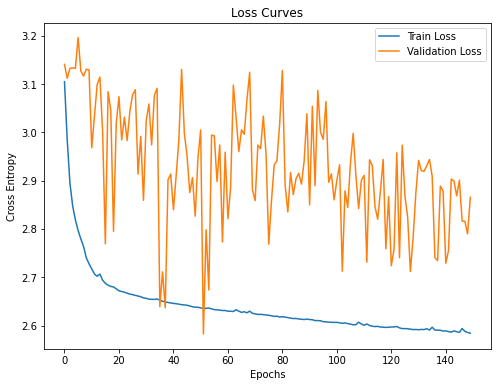

In [ ]:
plt.figure(figsize=(8,6))
plt.title("Loss Curves")
plt.plot(train_loss, label="Train Loss")
plt.plot(tune_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy")
plt.legend()
plt.show()

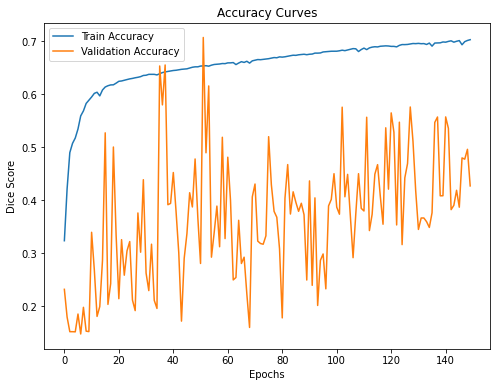

In [ ]:
plt.figure(figsize=(8,6))
plt.title("Accuracy Curves")
plt.plot(accuracy_train, label="Train Accuracy")
plt.plot(accuracy_tune, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Dice Score")
plt.legend()
plt.show()

In [ ]:
tune_data = ds_dict['tune']

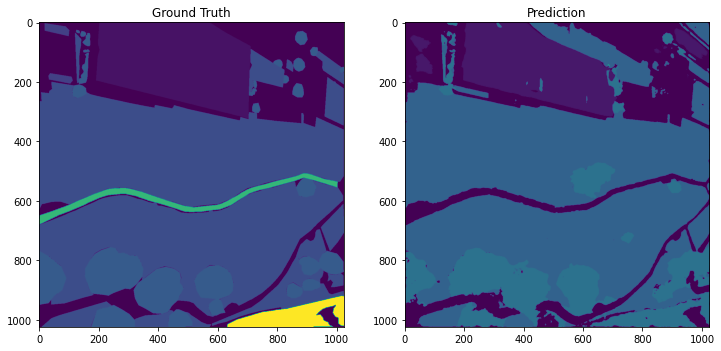

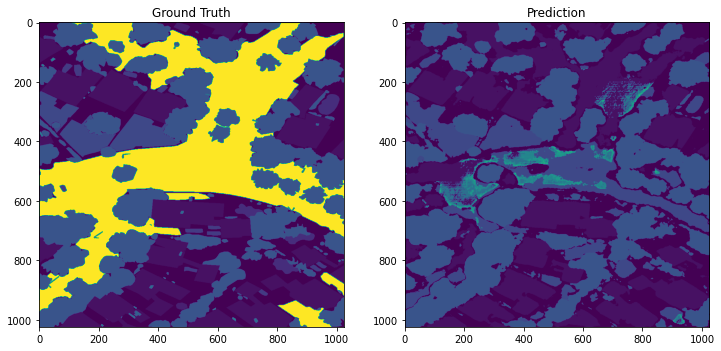

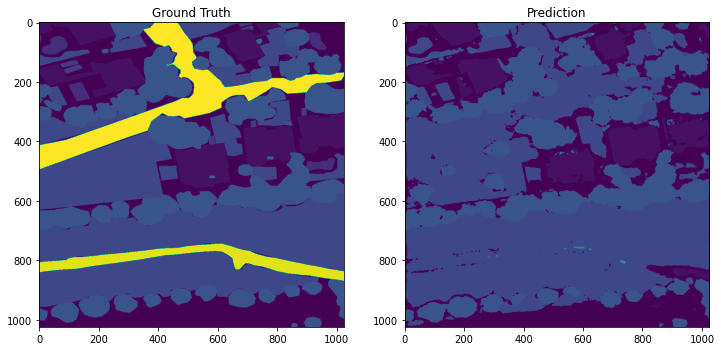

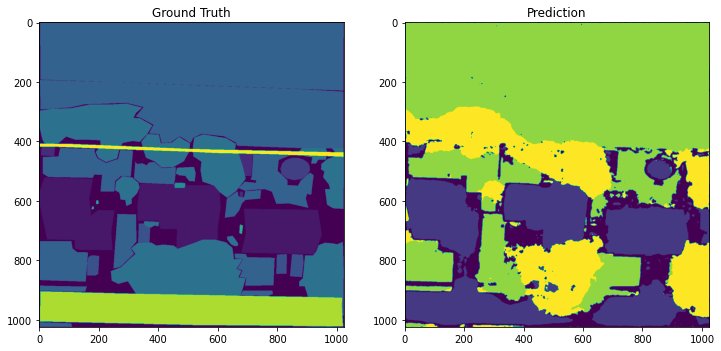

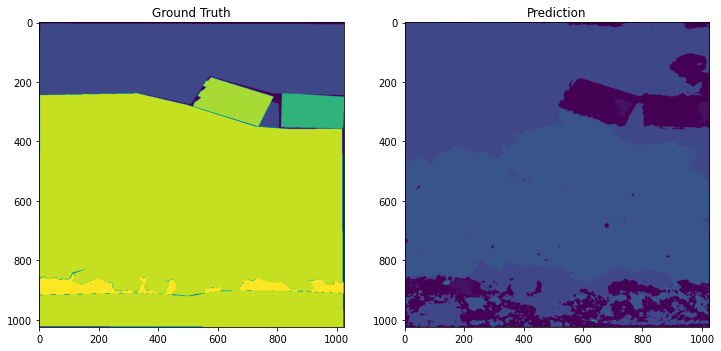

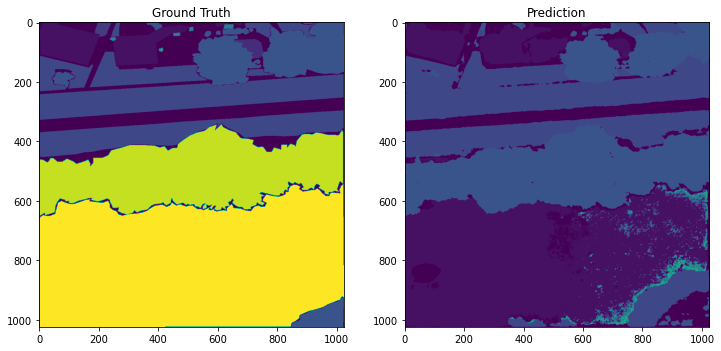

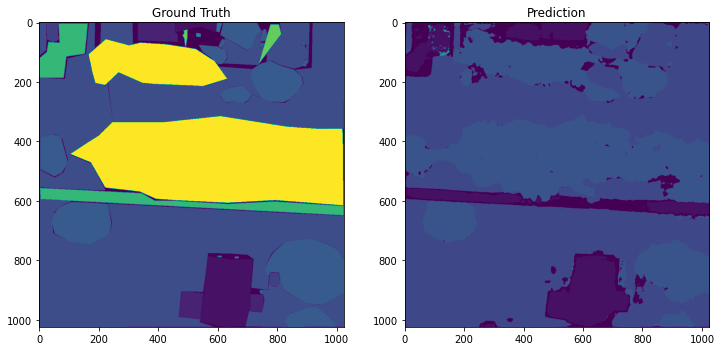

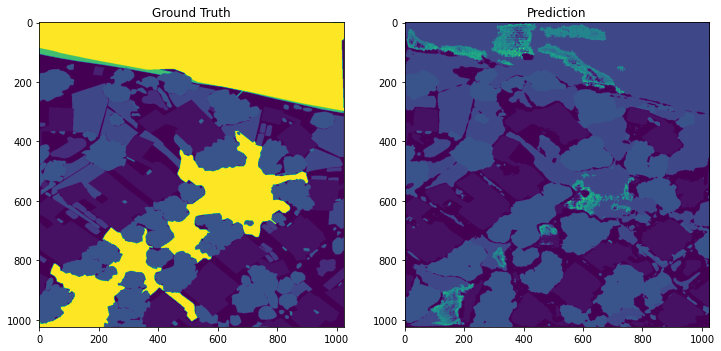

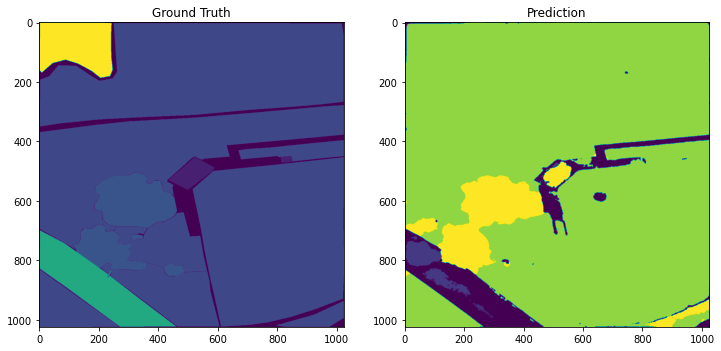

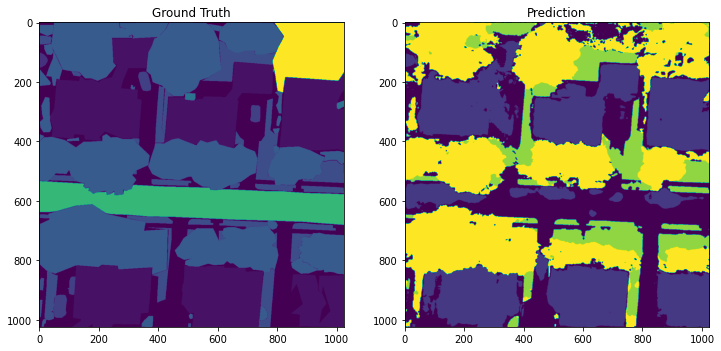

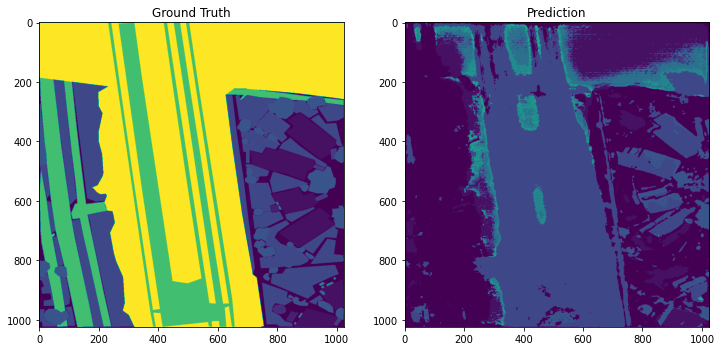

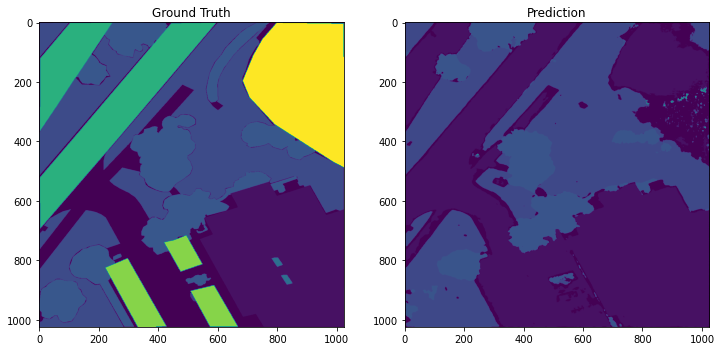

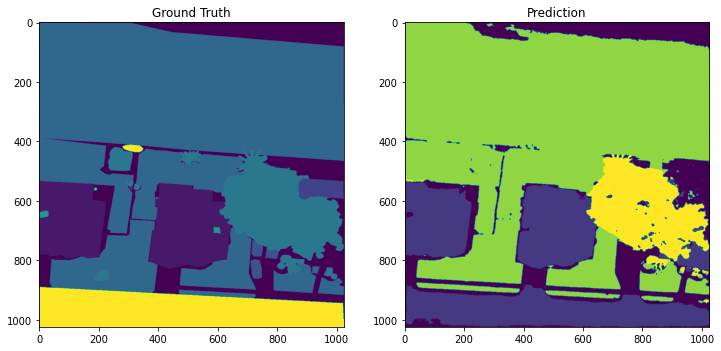

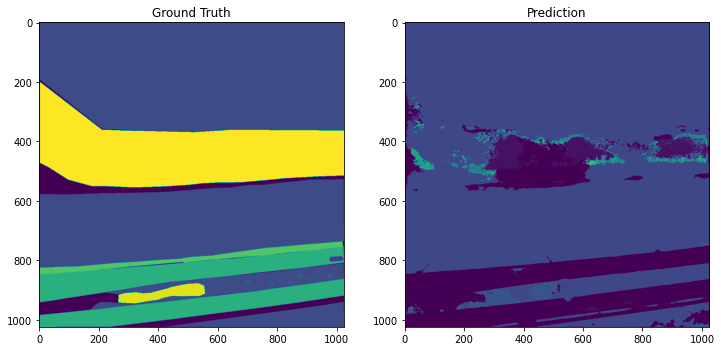

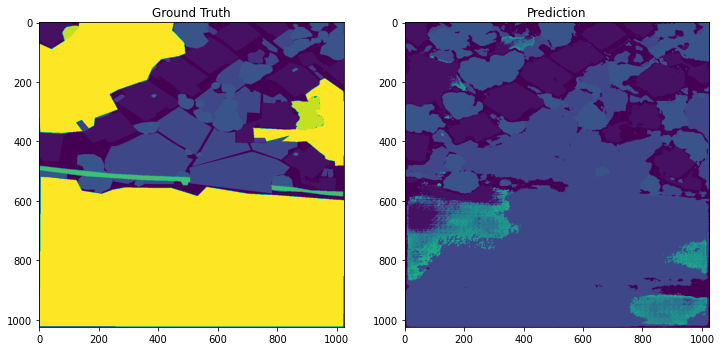

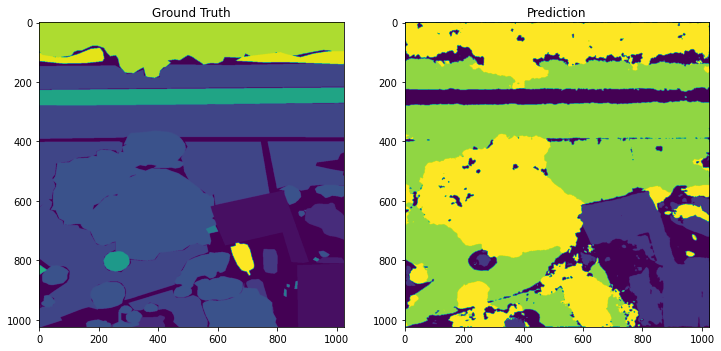

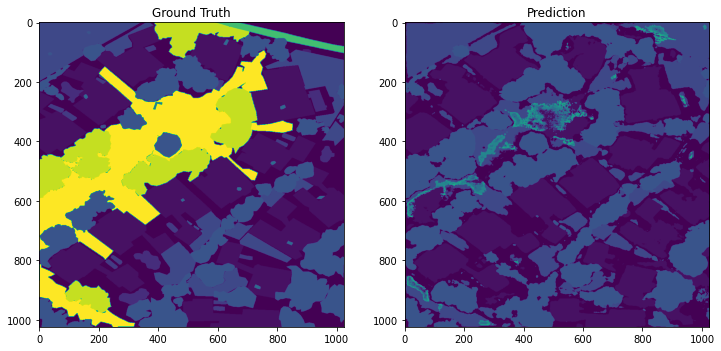

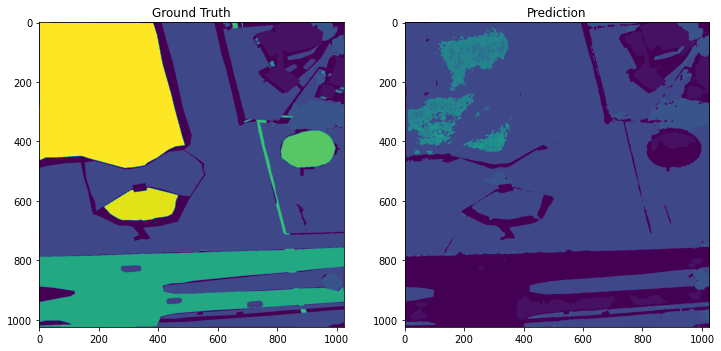

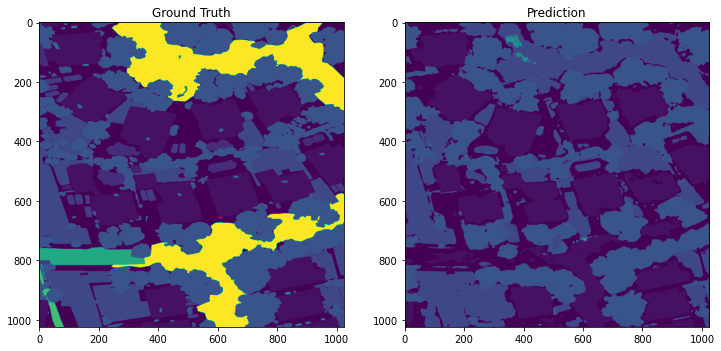

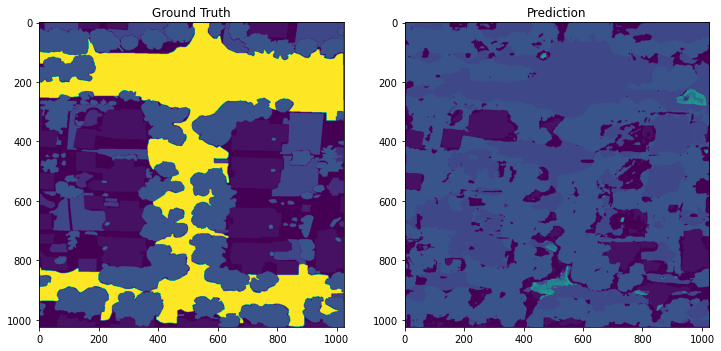

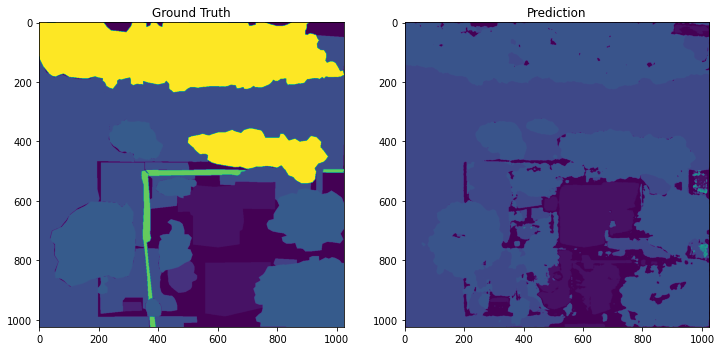

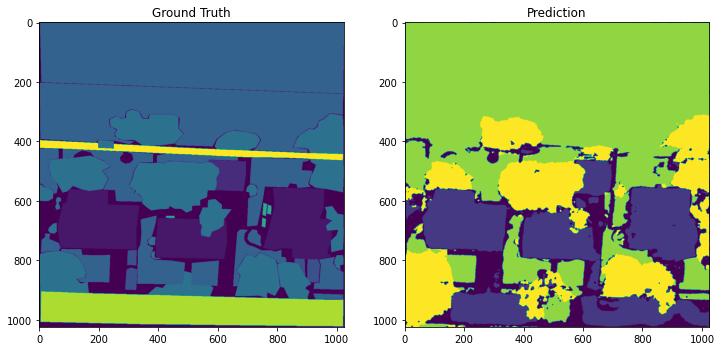

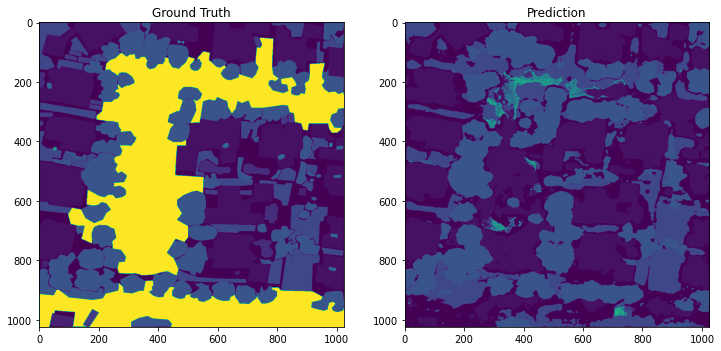

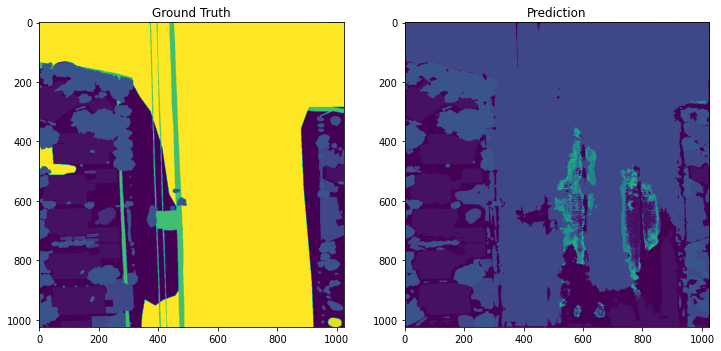

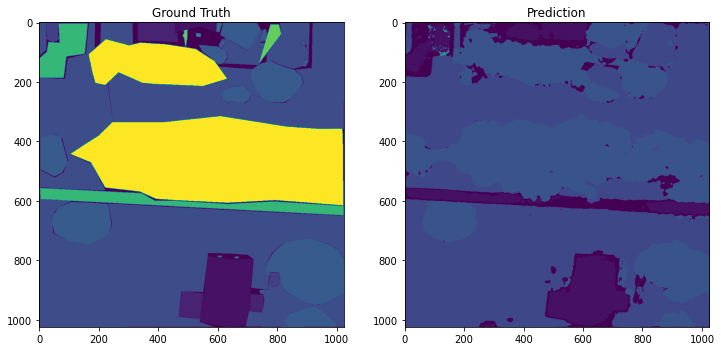

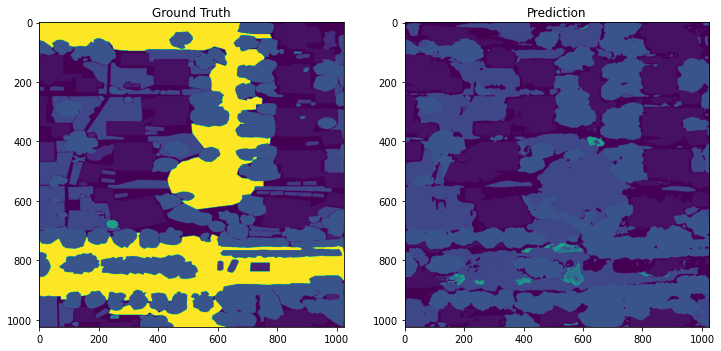

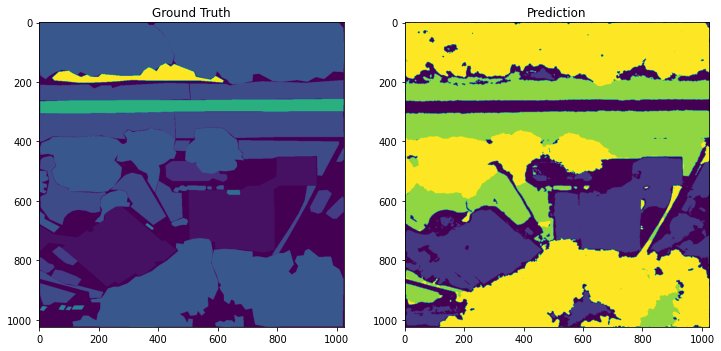

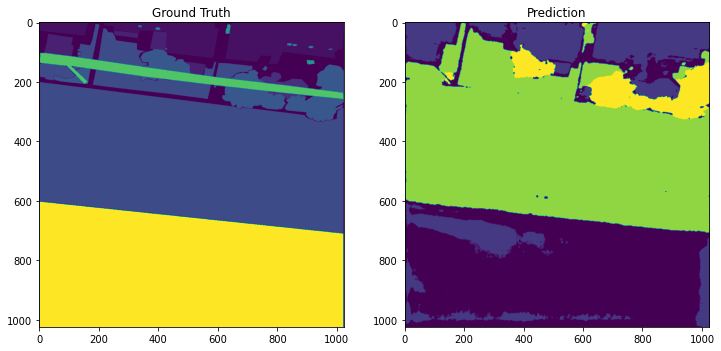

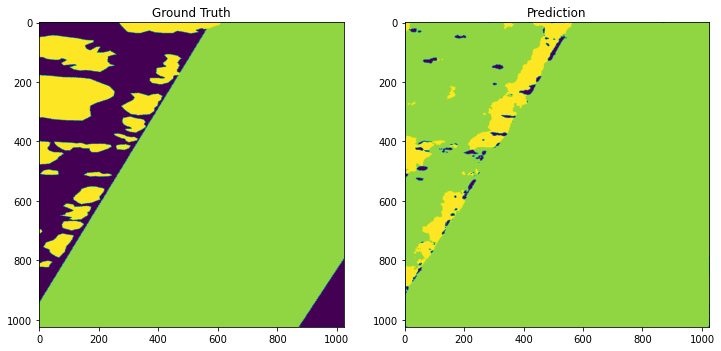

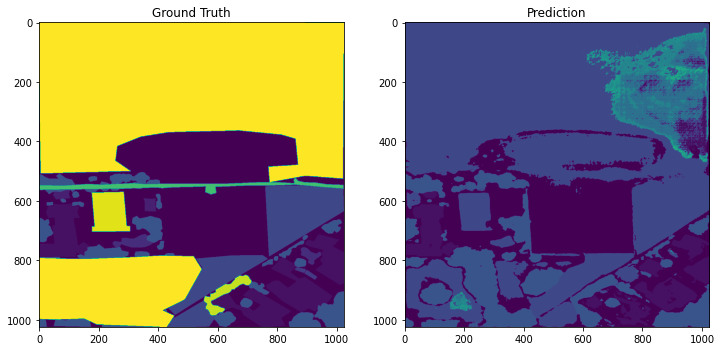

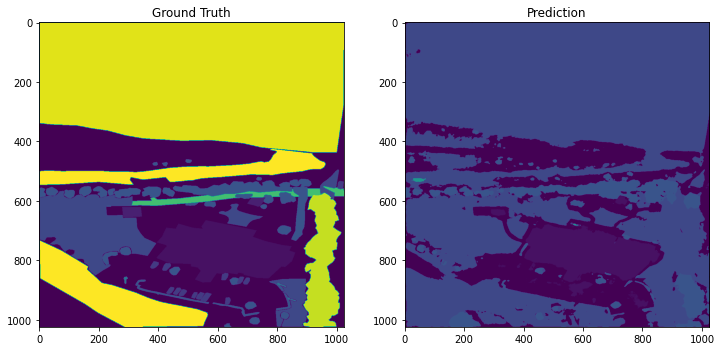

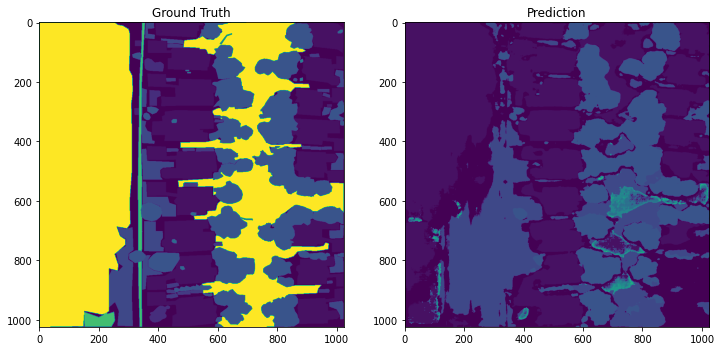

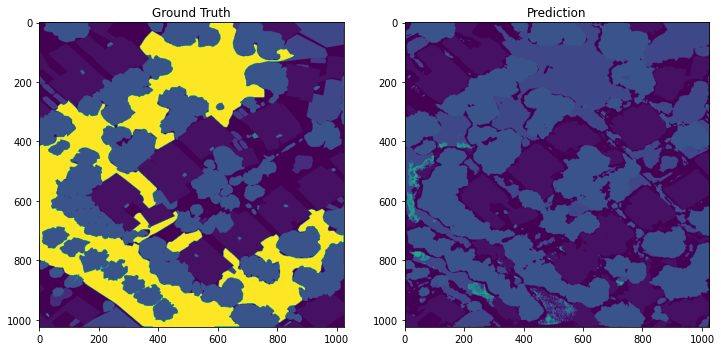

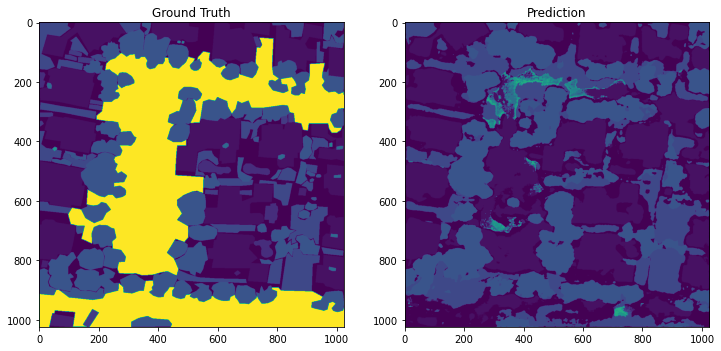

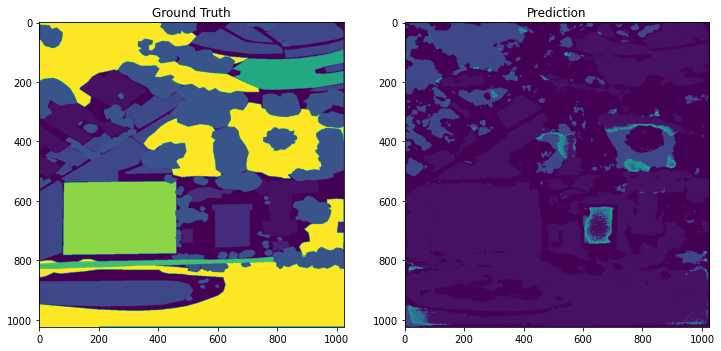

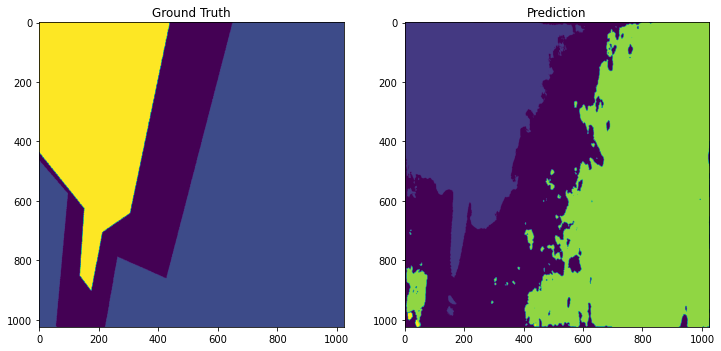

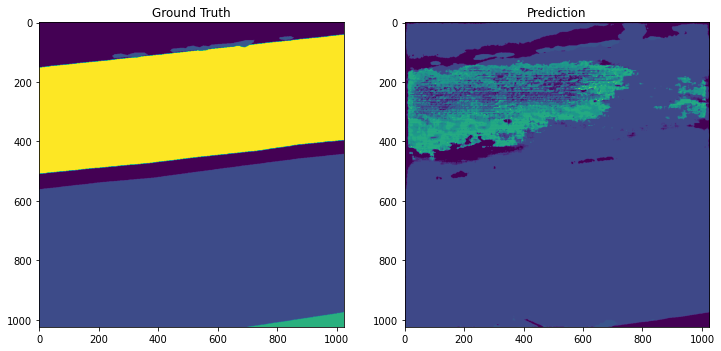

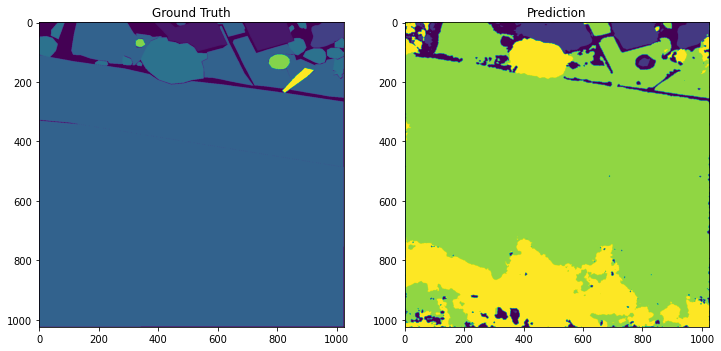

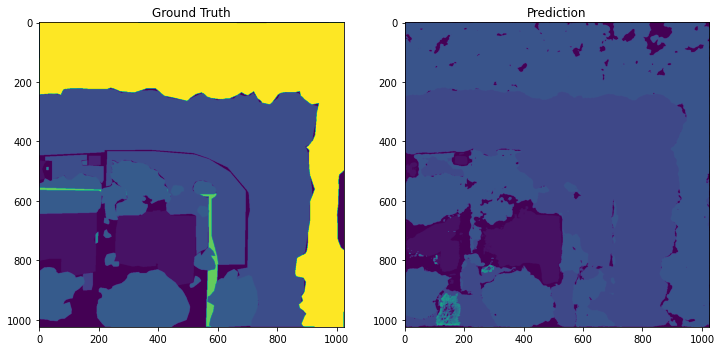

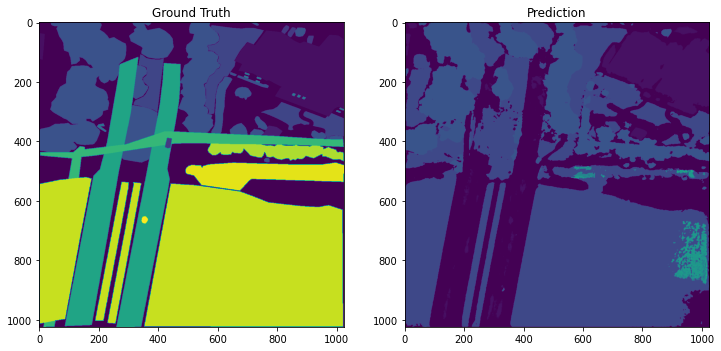

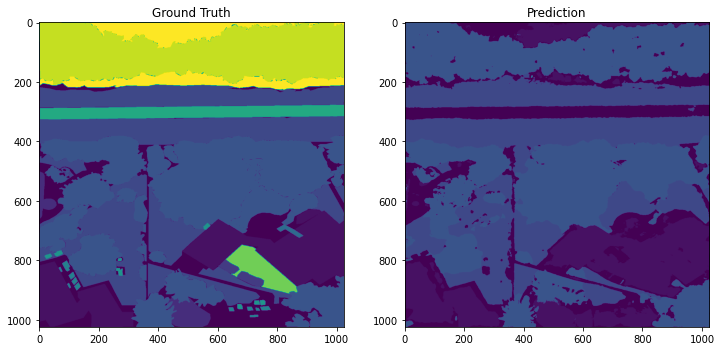

In [ ]:
for i, (x,y) in enumerate(tune_data):

  input_, label_ = x.to(device), y.to(device)
  y_pred = unet(torch.unsqueeze(input_,0))
  mask_pred = torch.squeeze(torch.argmax(y_pred, dim=1))
  label_ = label_.cpu().numpy()
  mask_pred = mask_pred.cpu().numpy()

  fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
  ax1.imshow(label_)
  ax1.set_title("Ground Truth")
  ax2.imshow(mask_pred)
  ax2.set_title("Prediction")
  plt.show()

## Making Predictions

In [ ]:
%ls "drive/MyDrive/Deep Learning - Group Project/models/"

base_model     base_model_12  base_model_3  base_model_6  base_model_9
base_model_10  base_model_13  base_model_4  base_model_7
base_model_11  base_model_14  base_model_5  base_model_8


In [ ]:
path = "drive/MyDrive/Deep Learning - Group Project/models/base_model_14"
model = UNet()
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
class TestDataset(Dataset):
    # resize_shape is in the format (height,width) (e.g. (4000,3000) for most of our dataset)
    def __init__(self, imagePaths, image_transform, resize_shape=(1024,1024)):
        # store the image and mask filepaths, and augmentation
        # transforms
        self.imagePaths = imagePaths
        self.image_transform = image_transform
        self.resize_shape = resize_shape

    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.imagePaths)

    def __getitem__(self, idx):
        # grab the image path from the current index
        imagePath = self.imagePaths[idx]

        # load the image from disk, swap its channels from BGR to RGB,
        # and read the associated mask from disk in grayscale mode
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # use INTER_AREA for image resize and INTER_NEAREST for mask resize
        image_res = cv2.resize(image, self.resize_shape, interpolation=cv2.INTER_AREA)

        # apply the transformations to both image and its mask
        image = self.image_transform(image_res)
        
        # return a tuple of the image and its mask
        return (image,os.path.basename(imagePath)[:-4])

In [ ]:
testPath = "drive/MyDrive/Deep Learning - Group Project/data/test_images/test_images/"
testPaths = [os.path.join(testPath,path) for path in os.listdir(testPath)]

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

In [ ]:
testset = TestDataset(testPaths, transform)

In [ ]:
predPath = "drive/MyDrive/Deep Learning - Group Project/data/test_preds/"

In [ ]:
from PIL import Image

i=1
for image in testset:
  tens,name = image
  name = name + ".png"
  print("Predicting on image:",i,":",name)
  i += 1
  tens = tens.expand(1,3,1024,1024)
  pred = model(tens).squeeze()
  pred = torch.argmax(pred,0).numpy()
  save = cv2.imwrite(os.path.join(predPath,name), pred)

Predicting on image: 1 : 10170.png
Predicting on image: 2 : 10171.png
Predicting on image: 3 : 10184.png
Predicting on image: 4 : 10808.png
Predicting on image: 5 : 10566.png
Predicting on image: 6 : 6413.png
Predicting on image: 7 : 10812.png
Predicting on image: 8 : 6457.png
Predicting on image: 9 : 6424.png
Predicting on image: 10 : 6450.png
Predicting on image: 11 : 6427.png
Predicting on image: 12 : 6455.png
Predicting on image: 13 : 6465.png
Predicting on image: 14 : 6463.png
Predicting on image: 15 : 6462.png
Predicting on image: 16 : 6466.png
Predicting on image: 17 : 6459.png
Predicting on image: 18 : 6476.png
Predicting on image: 19 : 6481.png
Predicting on image: 20 : 6504.png
Predicting on image: 21 : 6499.png
Predicting on image: 22 : 6492.png
Predicting on image: 23 : 6569.png
Predicting on image: 24 : 6550.png
Predicting on image: 25 : 6560.png
Predicting on image: 26 : 6546.png
Predicting on image: 27 : 6644.png
Predicting on image: 28 : 6574.png
Predicting on image: 29